_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Sarah Strauss, Cornelius Schröder

Summer term 2020

Due date: 2020-05-19, 9.15am

Student name: Shanqian Ma {1,2}, Weiyi Xiao {3,4}

# Exercise sheet 4

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `np.decimate`.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import oopsi  # xrange was changed to range for python3
sns.set_style('whitegrid')
%matplotlib inline


## Load data

In [2]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv('data//nda_ex_4_ogb_calcium.csv', header=0)  
ogb_spikes = pd.read_csv('data//nda_ex_4_ogb_spikes.csv', header=0)  

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv('data//nda_ex_4_gcamp_calcium.csv', header=0)  
gcamp_spikes = pd.read_csv('data//nda_ex_4_gcamp_spikes.csv', header=0)  

## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

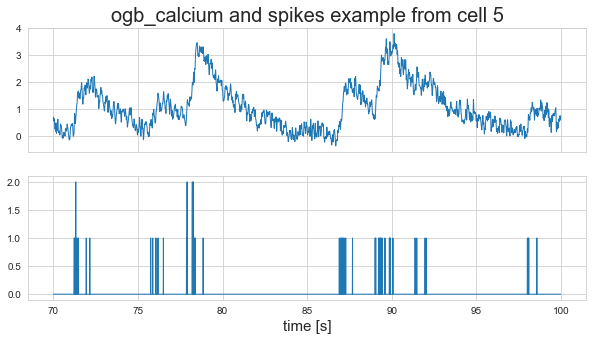

In [3]:
Fs = 100     # sampling rate of the signal in Hz
dt = 1/Fs
t1 = np.arange(0,ogb_calcium.shape[0]) * dt 
ts = 70  # start time
te = 100  # end time
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(10,5))
ax1.plot(t1[ts*Fs:te*Fs], ogb_calcium['4'][ts*Fs:te*Fs],linewidth=1)
ax1.set_title('ogb_calcium and spikes example from cell 5',fontsize=20)
ax2.plot(t1[ts*Fs:te*Fs], ogb_spikes['4'][ts*Fs:te*Fs],linewidth=1)
ax2.set_xlabel('time [s]',fontsize=15)
plt.show()

<Figure size 1080x360 with 0 Axes>

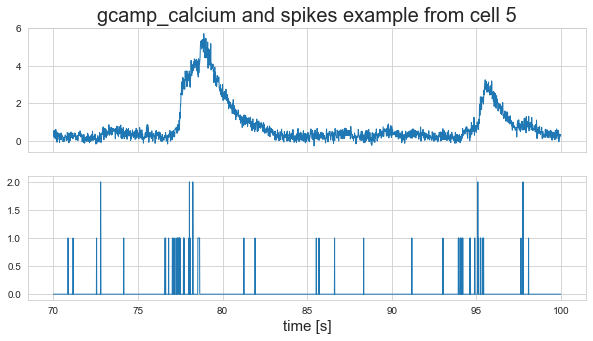

In [4]:
plt.figure(figsize=(15, 5))
t2 = np.arange(0,gcamp_calcium.shape[0]) * dt 
ts = 70  # start time
te = 100  # end time
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(10,5))
ax1.plot(t2[ts*Fs:te*Fs], gcamp_calcium['4'][ts*Fs:te*Fs],linewidth=1)
ax1.set_title('gcamp_calcium and spikes example from cell 5',fontsize=20)
ax2.plot(t2[ts*Fs:te*Fs], gcamp_spikes['4'][ts*Fs:te*Fs],linewidth=1)
ax2.set_xlabel('time [s]',fontsize=15)
plt.show()

The amplitude for calcium signals increases as spike density increases.

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`, including your interpretation of the iterative denoising procedure. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons.

*Grading: 3 pts*


In [5]:
def deconv_ca(ca, sp, tau):
# Compute the deconvolved calcium signal 
#   sp_hat = deconv_ca(ca, sp, tau) computes the deconvolved calcium signal
#   using the indicator dependent exponential calicum kernel.
#
#   ca:    1 by T
#   sp:    1 by T
#   tau:   1 by 1
#
#   sp_hat: 1 by T

   # fill your code here
    t = np.arange(0,2*tau,1/50) # choose kernal window (Yaksi & Friedrich,2006)
    K = np.exp(-t/tau)
    
    sp_hat,reminder =signal.deconvolve(ca,K)
    
    # heavyside function to clean the negative value
    sp_hat[np.where(sp_hat<0)]=0
    
    # to make the deconvolved signal be equal length to original signal
    sp_hat=np.concatenate((sp_hat,np.zeros(len(ca)-len(sp_hat))),axis=0)
    return sp_hat

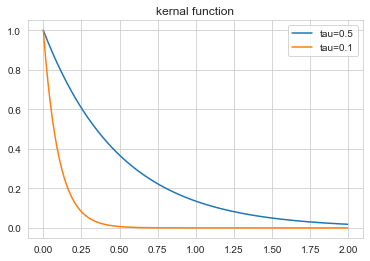

In [6]:
### plot the kernal function
t_k=np.arange(0,2,0.005)
plt.plot(t_k,np.exp(-t_k/0.5),label='tau=0.5')
plt.plot(t_k,np.exp(-t_k/0.1),label='tau=0.1')
plt.legend()
plt.title('kernal function')
plt.show()

#### Apply the function to the example OGB cell

In [7]:
idx = 4 # choose an example cell
ca_ogb = signal.decimate(ogb_calcium.iloc[:,idx], 4)
sp_ogb = signal.decimate(ogb_spikes.iloc[:,idx], 4)
sp_ogb[sp_ogb<0] = 0 # remove decimation artefacts

tau_ogb = .5

sp_hat_ogb = deconv_ca(ca_ogb, sp_ogb, tau_ogb)
print(sp_hat_ogb.shape)
print(sp_ogb.shape)

(17997,)
(17997,)


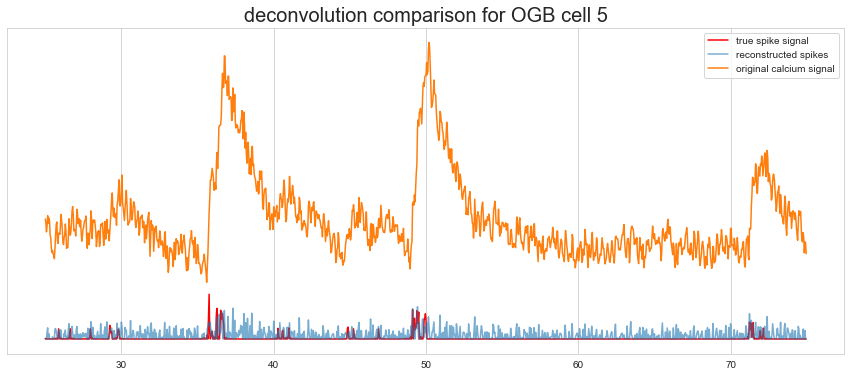

In [8]:
# fill in plot here
Fs_new = 25     # sampling rate after downsampling
dt_new = 1/Fs_new
t = np.arange(0,ca_ogb.shape[0]) * dt_new 
ts = 25  # start time
te = 75  # end time
plt.figure(figsize=(15, 6))
plt.plot(t[ts*Fs_new:te*Fs_new],sp_ogb[ts*Fs_new:te*Fs_new]-1.5,'r',label='true spike signal')
plt.plot(t[ts*Fs_new:te*Fs_new],sp_hat_ogb[ts*Fs_new:te*Fs_new]*0.8-1.5,alpha=0.6,label='reconstructed spikes')
plt.plot(t[ts*Fs_new:te*Fs_new],ca_ogb[ts*Fs_new:te*Fs_new],label='original calcium signal')
plt.yticks([])
plt.legend()
plt.title('deconvolution comparison for OGB cell 5',fontsize=20)
plt.show()

### Apply the function to the example GCamP cell

In [9]:
idx = 5
ca = signal.decimate(gcamp_calcium.iloc[:,idx], 4)
sp = signal.decimate(gcamp_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts

tau = .1

sp_hat = deconv_ca(ca, sp, tau)
print(ca.shape)
print(sp_hat.shape)

(4230,)
(4230,)


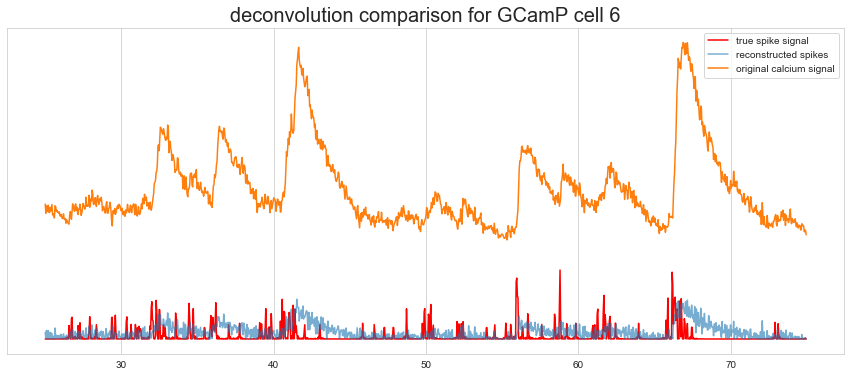

In [10]:
# fill in plot here
# fill in plot here
Fs_new = 25     # sampling rate after downsampling
dt_new = 1/Fs_new
t = np.arange(0,ca.shape[0]) * dt_new 
ts = 25  # start time
te = 75  # end time
plt.figure(figsize=(15,6))
plt.plot(t[ts*Fs_new:te*Fs_new],sp[ts*Fs_new:te*Fs_new]-1.5,'r',label='true spike signal')
plt.plot(t[ts*Fs_new:te*Fs_new],sp_hat[ts*Fs_new:te*Fs_new]*0.8-1.5,alpha=0.6,label='reconstructed spikes')
plt.plot(t[ts*Fs_new:te*Fs_new],ca[ts*Fs_new:te*Fs_new],label='original calcium signal')
plt.legend()
plt.yticks([])
plt.title('deconvolution comparison for GCamP cell 6',fontsize=20)
plt.show()

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

Note: If you have troubles with installing one of them maybe try another.

*Grading: 2 pts*



In [11]:
idx = 4
ca = signal.decimate(ogb_calcium.iloc[:,idx], 4)
sp = signal.decimate(ogb_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts

# fill in algorithm here
f = 25 # Hz
dt=1/f
sp_hat,C = oopsi.fast(ca,dt=dt,iter_max=6) # returns reconstructed spikes and clean calcium trace

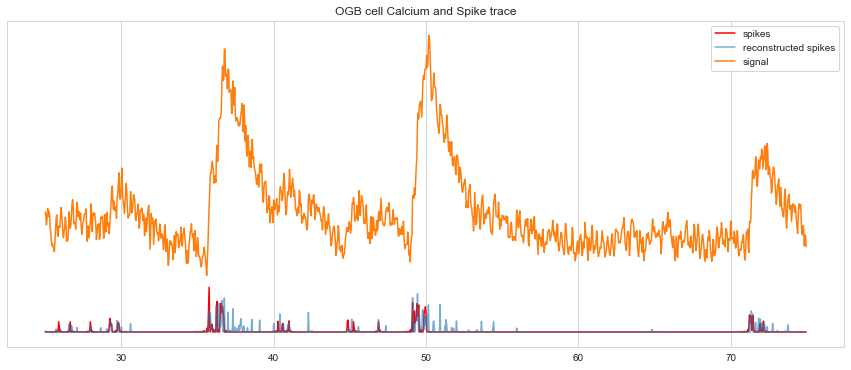

In [12]:
# fill in plot here
f = 25 # Hz
dt = 1/f
T =50
t = np.arange(0,T,dt)
numSamples = T*f 
offset=int(2500/4)
plt.figure(figsize=(15, 6))
plt.plot(t+offset/f,sp[offset:numSamples+offset]-1.5,'r',label='spikes')
plt.plot(t+offset/f,sp_hat[offset:numSamples+offset]*0.8-1.5,alpha=0.6,label='reconstructed spikes')
plt.plot(t+offset/f,ca[offset:numSamples+offset],label='signal')
plt.title("OGB cell Calcium and Spike trace")
ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
plt.legend()
plt.show()

In [13]:
idx = 5
ca = signal.decimate(gcamp_calcium.iloc[:,idx], 4)
sp = signal.decimate(gcamp_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts

# fill in algorithm here
f = 25 # Hz
dt=1/f
sp_hat,C = oopsi.fast(ca,dt=dt,iter_max=6) # returns reconstructed spikes and clean calcium trace

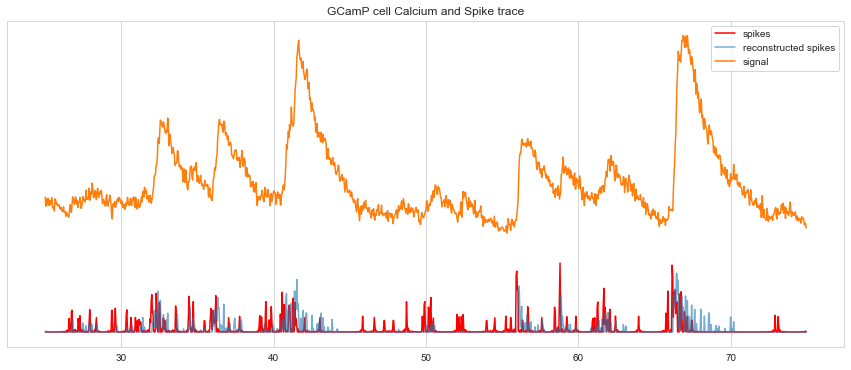

In [14]:
# fill in plot here
f = 25 # Hz
dt = 1/f
T =50
t = np.arange(0,T,dt)
numSamples = T*f 
offset=int(2500/4)
plt.figure(figsize=(15, 6))
plt.plot(t+offset/f,sp[offset:numSamples+offset]-1.5,'r',label='spikes')
plt.plot(t+offset/f,sp_hat[offset:numSamples+offset]*0.8-1.5,alpha=0.6,label='reconstructed spikes')
plt.plot(t+offset/f,ca[offset:numSamples+offset],label='signal')
plt.title("GCamP cell Calcium and Spike trace")
ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
plt.legend()
plt.show()

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation coefficient between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [15]:
tau = .5
f = 25 # Hz
dt = 1/f
numCell = ogb_calcium.shape[1]
ogb_corr_deconv = []
ogb_corr_oopsi = []
for idx in range(numCell):
    ca = signal.decimate(ogb_calcium.iloc[:,idx], 4)
    sp = signal.decimate(ogb_spikes.iloc[:,idx], 4)
    #convert nan to zero if detected
    ca[np.isnan(ca)]=0
    sp[np.isnan(sp)]=0
    # remove decimation artefacts
    sp[sp<0] = 0
    if sum(ca)==0:  # no signal was left after down sampling
        ogb_corr_deconv.append(np.nan)
        ogb_corr_oopsi.append(np.nan)
    else:
        sp_hat_deconv = deconv_ca(ca, sp, tau)
        sp_hat_oopsi,C = oopsi.fast(ca,dt=dt,iter_max=6) # returns reconstructed spikes and clean calcium trace
        ogb_corr_deconv.append(np.corrcoef(sp_hat_deconv,sp)[0,1])
        ogb_corr_oopsi.append(np.corrcoef(sp_hat_oopsi,sp)[0,1])
print(ogb_corr_deconv)
print(ogb_corr_oopsi)

[0.37763006770204754, 0.14230962666057495, nan, nan, 0.2762432972160685, 0.26448775750490117, 0.2651244272829453, nan, 0.1550356397002964, nan, 0.18165422671637016]
[0.4922109457762157, 0.2655678361285691, nan, nan, 0.4808372455732401, 0.4475345824897039, 0.43657272530205604, nan, 0.3668760555253732, nan, 0.41758313377666445]


Create OGB dataframe

In [16]:
cell_name=[]
oopsi_tag=[]
deconv_tag=[]
indicator_tag=[]
for idx in range(numCell):
    cell_name.append( 'Cell '+str(idx+1))
    oopsi_tag.append('oopsi')
    deconv_tag.append('simple deconvolution')
    indicator_tag.append('OGB-1')

ogb_data = {'cell':cell_name+cell_name,'algorithm':deconv_tag+oopsi_tag, 'correlation': ogb_corr_deconv+ogb_corr_oopsi, 'indicator':indicator_tag+indicator_tag} 
ogb_df = pd.DataFrame(ogb_data) 

Evaluate on GCamp data

In [17]:
tau = .1
f = 25 # Hz
dt = 1/f
numCell = gcamp_calcium.shape[1]
gcamp_corr_deconv = []
gcamp_corr_oopsi = []
for idx in range(numCell):
    ca = signal.decimate(gcamp_calcium.iloc[:,idx], 4)
    sp = signal.decimate(gcamp_spikes.iloc[:,idx], 4)
    #convert nan to zero if detected
    ca[np.isnan(ca)]=0
    sp[np.isnan(sp)]=0
    # remove decimation artefacts
    sp[sp<0] = 0
    if sum(ca)==0:  # no signal was left after down sampling
        gcamp_corr_deconv.append(np.nan)
        gcamp_corr_oopsi.append(np.nan)
    else:
        sp_hat_deconv = deconv_ca(ca, sp, tau)
        sp_hat_oopsi,C = oopsi.fast(ca,dt=dt,iter_max=6) # returns reconstructed spikes and clean calcium trace
        gcamp_corr_deconv.append(np.corrcoef(sp_hat_deconv,sp)[0,1])
        gcamp_corr_oopsi.append(np.corrcoef(sp_hat_oopsi,sp)[0,1])
print(gcamp_corr_deconv)
print(gcamp_corr_oopsi)

[0.09700426237637821, 0.09707304374886476, 0.4956926360934657, 0.24836848418138216, 0.24279476991057455, 0.12519566095490225, 0.24257806155839812, 0.1425478102839299, 0.06340437465798247]
[0.11837517716376549, 0.10483908903939877, 0.343293363823394, 0.27654766239370443, 0.2920859924408187, 0.19356280172452253, 0.24360763920671125, 0.18796430005842998, 0.04927651282859163]


Create GCamp dataframe

In [18]:
cell_name=[]
oopsi_tag=[]
deconv_tag=[]
indicator_tag=[]
for idx in range(numCell):
    cell_name.append( 'Cell '+str(idx+1))
    oopsi_tag.append('oopsi')
    deconv_tag.append('simple deconvolution')
    indicator_tag.append('GCamp6f')

gcamp_data = {'cell':cell_name+cell_name,'algorithm':deconv_tag+oopsi_tag, 'correlation': gcamp_corr_deconv+gcamp_corr_oopsi, 'indicator':indicator_tag+indicator_tag} 
gcamp_df = pd.DataFrame(gcamp_data) 


Combine both dataframes and plot

In [19]:
# note cell 1 with OGB-1 is different with cell 1 with GCamp6f
data =  pd.concat([ogb_df, gcamp_df], axis=0)  #vertical concatination

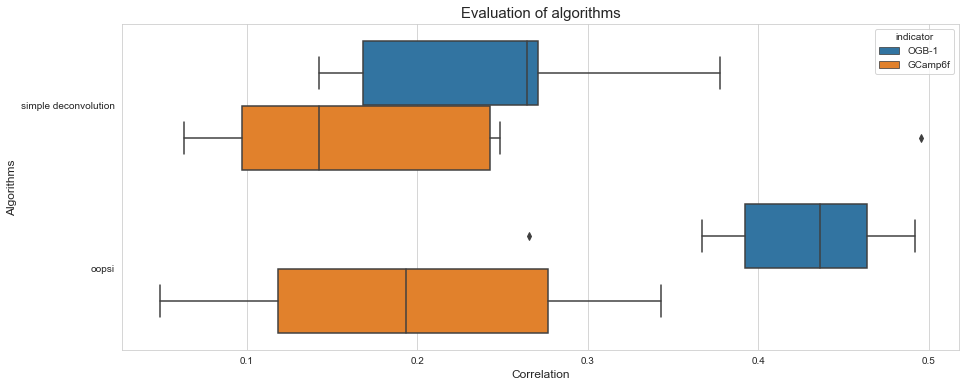

In [20]:
plt.figure(figsize=(15, 6))
sns.boxplot( y=data["algorithm"], x=data["correlation"], hue=data["indicator"])
plt.title('Evaluation of algorithms',fontsize=15)
plt.xlabel('Correlation',fontsize=12)
plt.ylabel('Algorithms',fontsize=12)
plt.show()

oopsi is better than simple deconvolution. For both indicators, oopsi shows a higher correlation between reconstructed spikes and real spikes, which means oopsi gives a more accurate result.